### Corrective RAG

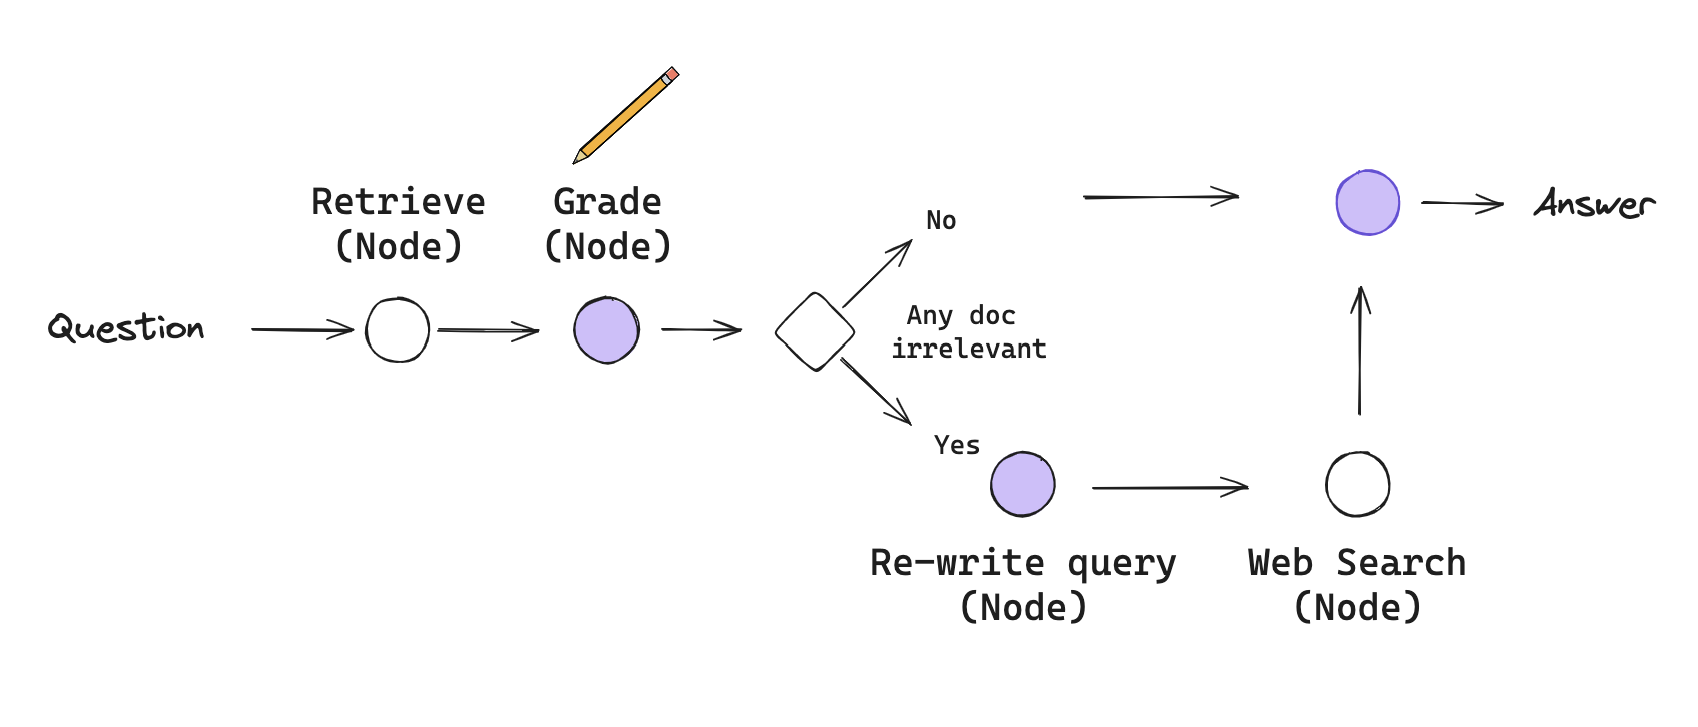

In [3]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [4]:
### Build Index

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import FastEmbedEmbeddings

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = FastEmbedEmbeddings()

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=FastEmbedEmbeddings()
)


retriever=vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = init_chat_model(model="groq:openai/gpt-oss-20b", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
##chain the prompt with the LLM
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [7]:
### Generate

from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = init_chat_model(model="groq:openai/gpt-oss-20b", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory in LLM‑powered agents is split into two layers.  
Short‑term memory is the in‑context prompt that lets the model “learn” from recent dialogue or instructions.  
Long‑term memory stores past experiences in an external vector store, enabling fast retrieval and recall over extended periods.


In [8]:
### Question Re-writer

# LLM
llm = init_chat_model(model="groq:openai/gpt-oss-20b", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the common memory architectures used in AI agents, and how do they influence learning and decision‑making?'

In [9]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\USER\AppData\Local\Temp\ipykernel_17712\730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [10]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [11]:
from langchain_core.documents import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [12]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

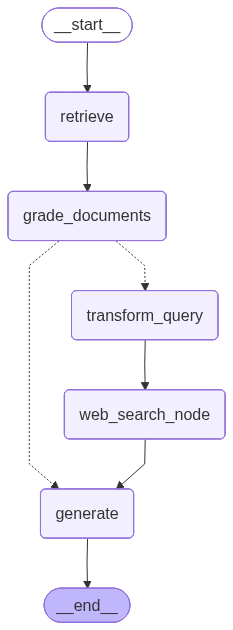

In [13]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [14]:
app.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---


{'question': 'What are the different types of memory used by AI agents?',
 'generation': 'AI agents typically use **short‑term (contextual) memory** to hold the immediate conversation or task state within a single session, often via the LLM’s prompt window. They also employ **long‑term memory** that persists across sessions, implemented with external vector stores, knowledge bases, or databases to retrieve past facts, experiences, or user preferences. Some systems further distinguish **episodic memory** (specific past events) and **semantic memory** (general knowledge) to support case‑based reasoning and domain expertise.',
 'web_search': 'Yes',
 'documents': [Document(id='38626fce-1be5-40f5-af4e-c79796f0873c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as Auto